# Import/Initialize

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tqdm import tqdm

import time
from PIL import Image
import cv2
from skimage.color import rgba2rgb
from skimage.io import imread
import copy

from collections import OrderedDict

In [2]:
CHANNEL_N = 16
RADIUS = 1
NUM_FILTERS = 6
HIDDEN_N = 128
# HIDDEN_N = [128, CHANNEL_N]

EMBED_KERNEL = 5

TARGET_SIZE = 40
TARGET_PADDING = 16
BATCH_SIZE = 1

In [3]:
class Filter(nn.Module):
    def __init__(self, r=RADIUS, symmetric=True):
        super().__init__()
        
        
        f = torch.randn(2*r + 1)
        if symmetric:
            f = (f + f.flip(0))/2
        f = torch.ger(f, f)
#         f[r, r] = 0
        f = f - f.mean()
#         f = f - f.sum()/(f.numel() - 1)
        f[r, r] = 0
        f = f / (f.numel() - 1)
        
        self.kernel = nn.Parameter(f)


class CAModel(nn.Module):
    def __init__(self, channel_n=CHANNEL_N, r=RADIUS, num_filters=NUM_FILTERS, hidden_n=HIDDEN_N):
        super().__init__()            
        
        self.channel_n = channel_n
        self.r = r
        self.num_filters = num_filters
        self.fire_rate = 0.5
        
        # define identity matrix
        identity = torch.zeros(2*self.r + 1)
        identity[self.r] = 1
        self.identity = torch.ger(identity, identity)
        self.identity = nn.Parameter(self.identity, requires_grad=False)

        # initialize perception kernel (trainable) 
        self.rand_filters = [Filter(self.r, symmetric=True).kernel for i in range(self.num_filters)]
        
        self.filters = nn.ParameterList([self.identity] + self.rand_filters)
        
        # Sobel filters
#         self.sx = torch.ger(torch.FloatTensor([1, 2, 1]), torch.FloatTensor([-1, 0, 1])) / 8
#         self.sx = nn.Parameter(self.sx, requires_grad=False)
#         self.sy = nn.Parameter(self.sx.T.type(torch.FloatTensor), requires_grad=False)
#         self.filters = [torch.cuda.FloatTensor(self.sx), torch.cuda.FloatTensor(self.sy)]
        
        
        # 1D conv network
        self.dmodel = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(self.channel_n*(self.num_filters + 1), hidden_n, 1, padding_mode='circular')),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(hidden_n, self.channel_n, 1, padding_mode='circular')),
        ]))
        
        # 1D conv network
#         self.dmodel = [nn.Conv2d(self.channel_n*(self.num_filters + 1), hidden_n[0], 1, padding_mode='circular')]
#         self.dmodel.append(nn.LeakyReLU())
#         for i in range(1, len(hidden_n)):
#             l = nn.Conv2d(hidden_n[i-1], hidden_n[i], 1, padding_mode='circular')
#             self.dmodel.append(l)
#             if i < (len(hidden_n) - 1):
#                 self.dmodel.append(nn.LeakyReLU())
        
        gain=nn.init.calculate_gain('leaky_relu')
#         for l in self.dmodel:
#             if type(l) == nn.Conv2d:
#                 nn.init.xavier_uniform_(l.weight, gain)
#         self.dmodel = nn.Sequential(*self.dmodel)
        
        # update rule - initialized with zeros so initial behaviour is 'do nothing' (trainable)
#         gain=nn.init.calculate_gain('relu')
#         nn.init.zeros_(self.dmodel.conv2.weight)
#         nn.init.zeros_(self.dmodel.conv2.bias)

        nn.init.xavier_uniform_(self.dmodel.conv1.weight, gain)
#         nn.init.zeros_(self.dmodel.conv2.bias)

        nn.init.xavier_uniform_(self.dmodel.conv2.weight, gain)

         
    def perceive(self, x):              
#         filters = [self.identity] + [f.kernel for f in self.rand_filters]
#         filters = [self.identity, self.sx, self.sy]
        filters = [f for f in self.filters]
        numFilters = len(filters)
        k_size = 2*self.r + 1
        
        filters = torch.stack(filters).unsqueeze(0)
        filters = torch.repeat_interleave(filters, self.channel_n, dim=0)
        filters = filters.view(self.channel_n*numFilters, 1, k_size, k_size)  # combine filters into batch dimension (or out dimension, idk)
        
        # depthwise conv2d (groups==self.channel_n)
        x = F.pad(x, (self.r, self.r, self.r, self.r), mode='circular')
        y = F.conv2d(x, filters, padding=self.r, groups=self.channel_n) 
        y = y[:, :, self.r:-self.r, self.r:-self.r]
        return y
    
    def get_living_mask(self, x):
        alpha_channel = x[:, 3:4, :, :]
        alpha_channel = F.pad(alpha_channel, (self.r, self.r, self.r, self.r), mode='circular')

        alive_mask = F.max_pool2d(alpha_channel, kernel_size=2*self.r+1, stride=1, padding=self.r) > 0.1
        alive_mask = alive_mask[:, :, self.r:-self.r, self.r:-self.r] 
        
        death_mask = F.avg_pool2d(alpha_channel, kernel_size=2*self.r+1, stride=1, padding=self.r) < 0.2
        death_mask = death_mask[:, :, self.r:-self.r, self.r:-self.r] 
        return alive_mask.cuda() & death_mask.cuda()
    
    def forward(self, x, fire_rate=None, step_size=1.0):
        
        pre_life_mask = self.get_living_mask(x)
        
        y = self.perceive(x)
        dx = self.dmodel(y) * step_size 
        
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = (torch.rand(x[:, :1, :, :].shape) <= fire_rate).type(torch.FloatTensor).cuda()
        x = x + dx * update_mask
        
        post_life_mask = self.get_living_mask(x)
        life_mask = (pre_life_mask & post_life_mask).type(torch.FloatTensor).cuda()
        
        x = x * life_mask
 
        return x

class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c1 = nn.Conv2d(CHANNEL_N, 32, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular')
        self.c2 = nn.Conv2d(32, 32, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular')
        self.c3 = nn.Conv2d(32, 32, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular')
        self.c4 = nn.Conv2d(32, 8, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular')
        
    def forward(self, x):
        z = torch.tanh(self.c1(x))
        z = F.leaky_relu(self.c2(z))
        z = F.leaky_relu(self.c3(z))
        z = self.c4(z)
        
        return z

def to_rgba(x):
    return x[:, :4, :, :]

def to_alpha(x):
    return np.clip(x[:, 3:4, :, :], 0.0, 1.0)

def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[:, :3, :, :], to_alpha(x)
    return 1.0-a+rgb

def load_image(fname, max_size=TARGET_SIZE):
    img = Image.open(fname)
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img

# Run for fun (remove zero weight initialization on final layer)

In [4]:
CA_run = CAModel()

if torch.cuda.is_available():
    CA_run.cuda()

450


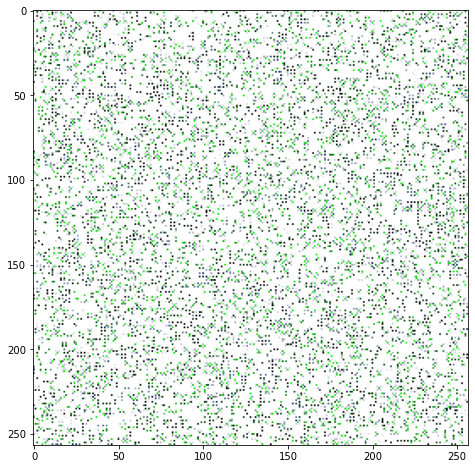

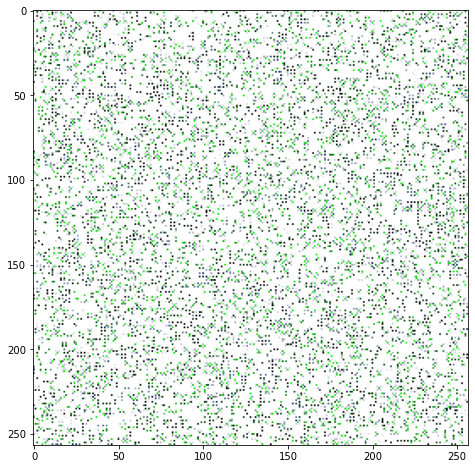

In [5]:
SIZE = 257

x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, SIZE, SIZE))).unsqueeze(0) > 3
x = x.type(torch.cuda.FloatTensor)
# x = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
# x[:, 3:, SIZE//2, SIZE//2] = 1
# x[:, 3:, 256//3 : 2*256//3, 256//3 : 2*256//3] = 1

# x[:, 3:, SIZE//3, SIZE//3] = 1
# x[:, 3:, 2*SIZE//3, 2*SIZE//3] = 1

imgs = []

timeSteps = 500
for i in range(timeSteps):
#     print(i, stop)
    nx = x.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
    nx = rgba2rgb(nx)
    imgs.append(nx)
    
    if i%50 == 0:
        plt.clf()
        plt.imshow(nx)
        plt.gcf().set_size_inches((8,8))
        clear_output(wait=True)
        print(f'{i}')
        display(plt.gcf())
        time.sleep(0.01)

    x = torch.tanh(CA_run.forward(x, step_size=1, fire_rate=1))
    x = x.detach()
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

In [363]:
fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 150, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Train

In [126]:
seed = 10000
np.random.seed(seed)
torch.manual_seed(seed)

CA = CAModel()
embed = Embedder().cuda()
if torch.cuda.is_available():
    CA.cuda()
    embed.cuda()

In [127]:
optim_emb = torch.optim.Adam([p for p in embed.parameters()], lr=1e-3)
optim_ca = torch.optim.Adam([p for p in CA.parameters()], lr=1e-3)

t=0, loss_emb=0.9974, loss_ca=0.9974


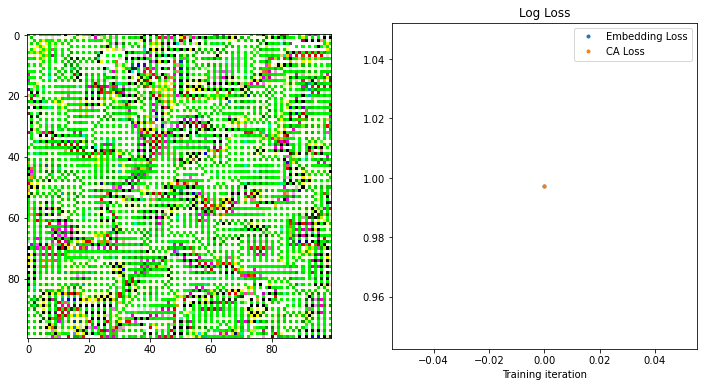

t=1, loss_emb=0.9995, loss_ca=0.9995
t=2, loss_emb=0.9933, loss_ca=0.9933
t=3, loss_emb=0.9794, loss_ca=0.9794
t=4, loss_emb=0.9959, loss_ca=0.9959
t=5, loss_emb=0.9224, loss_ca=0.9224


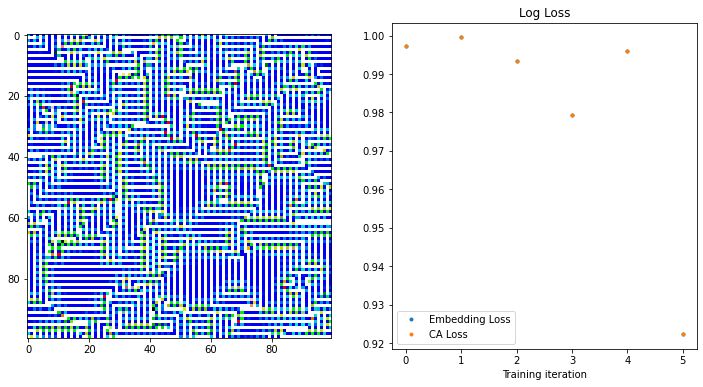

t=6, loss_emb=0.9639, loss_ca=0.9639
t=7, loss_emb=0.9649, loss_ca=0.9649
t=8, loss_emb=0.9528, loss_ca=0.9528
t=9, loss_emb=0.9364, loss_ca=0.9364
t=10, loss_emb=0.9245, loss_ca=0.9245


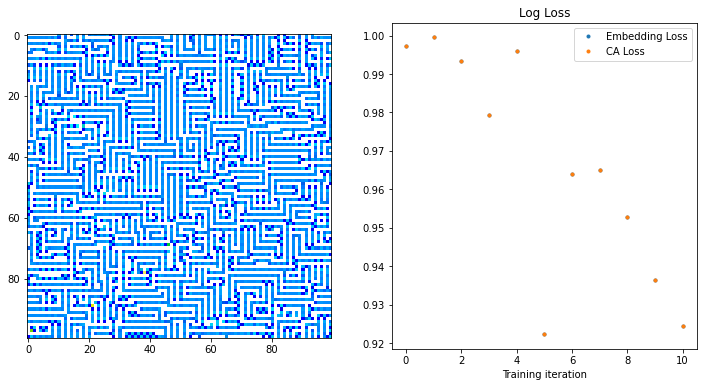

t=11, loss_emb=0.9303, loss_ca=0.9303
t=12, loss_emb=0.9236, loss_ca=0.9236
t=13, loss_emb=0.8538, loss_ca=0.8538
t=14, loss_emb=0.8952, loss_ca=0.8952
t=15, loss_emb=0.8582, loss_ca=0.8582


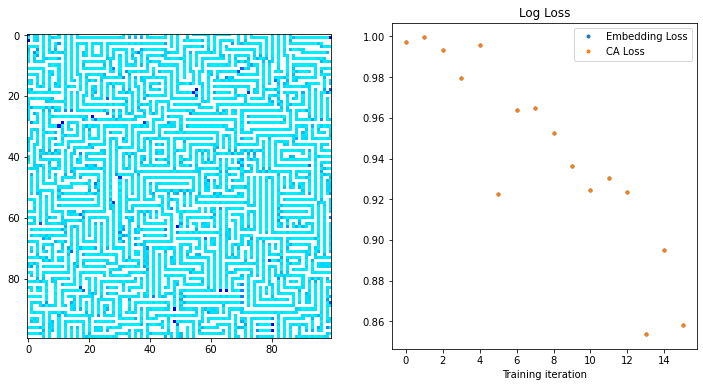

t=16, loss_emb=0.8387, loss_ca=0.8387
t=17, loss_emb=0.8719, loss_ca=0.8719
t=18, loss_emb=0.9088, loss_ca=0.9088
t=19, loss_emb=0.8304, loss_ca=0.8304
t=20, loss_emb=0.7372, loss_ca=0.7372


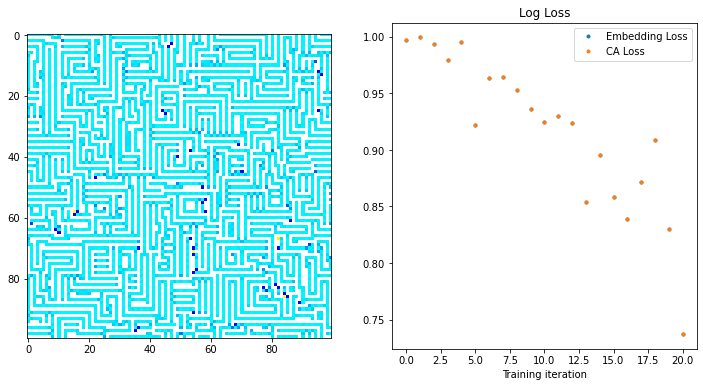

t=21, loss_emb=0.7803, loss_ca=0.7803
t=22, loss_emb=0.7410, loss_ca=0.7410
t=23, loss_emb=0.7909, loss_ca=0.7909
t=24, loss_emb=0.7723, loss_ca=0.7723
t=25, loss_emb=0.7168, loss_ca=0.7168


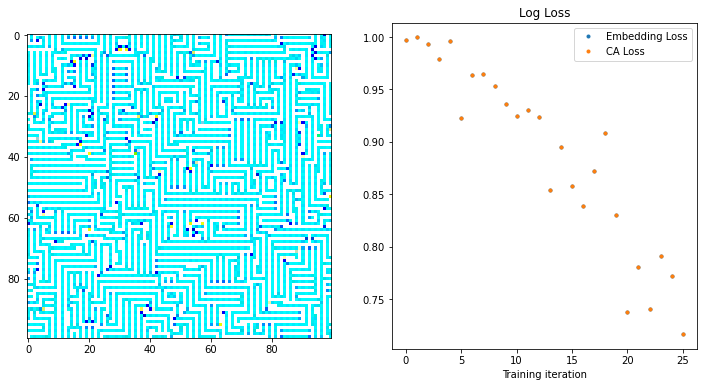

t=26, loss_emb=0.6849, loss_ca=0.6849
t=27, loss_emb=0.7151, loss_ca=0.7151
t=28, loss_emb=0.6772, loss_ca=0.6772
t=29, loss_emb=0.6560, loss_ca=0.6560
t=30, loss_emb=0.6780, loss_ca=0.6780


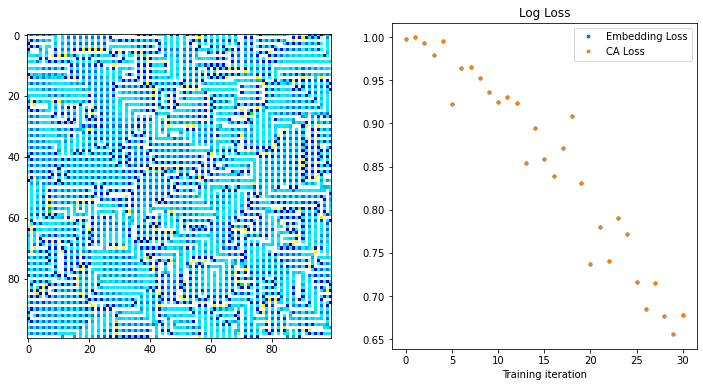

t=31, loss_emb=0.7121, loss_ca=0.7121
t=32, loss_emb=0.6868, loss_ca=0.6868
t=33, loss_emb=0.6632, loss_ca=0.6632
t=34, loss_emb=0.6806, loss_ca=0.6806
t=35, loss_emb=0.6539, loss_ca=0.6539


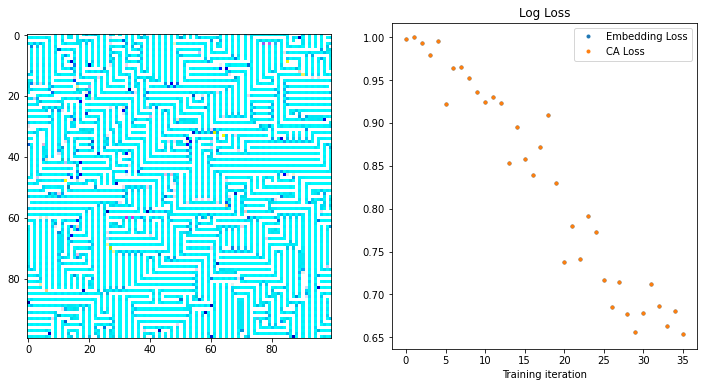

t=36, loss_emb=0.7019, loss_ca=0.7019
t=37, loss_emb=0.7001, loss_ca=0.7001
t=38, loss_emb=0.6176, loss_ca=0.6176
t=39, loss_emb=0.7281, loss_ca=0.7281
t=40, loss_emb=0.6589, loss_ca=0.6589


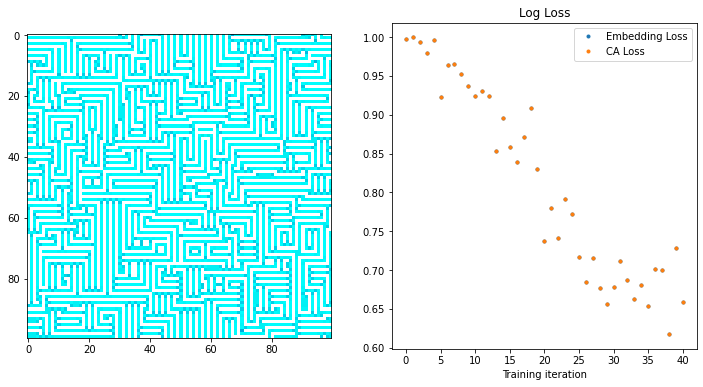

t=41, loss_emb=0.6214, loss_ca=0.6214
t=42, loss_emb=0.5610, loss_ca=0.5610
t=43, loss_emb=0.7015, loss_ca=0.7015
t=44, loss_emb=0.6239, loss_ca=0.6239
t=45, loss_emb=0.5105, loss_ca=0.5105


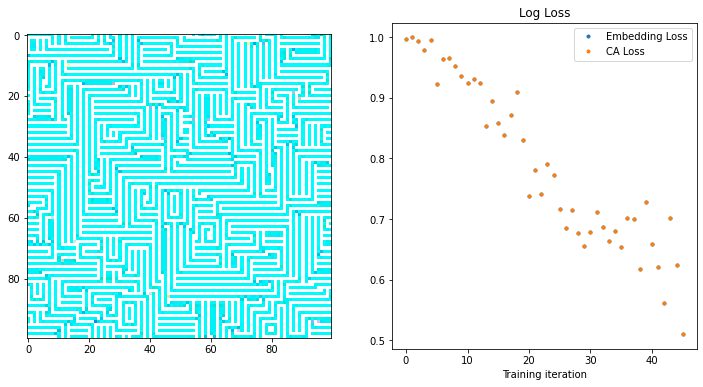

t=46, loss_emb=0.5613, loss_ca=0.5613
t=47, loss_emb=0.5156, loss_ca=0.5156
t=48, loss_emb=0.5200, loss_ca=0.5200
t=49, loss_emb=0.4924, loss_ca=0.4924
t=50, loss_emb=0.4389, loss_ca=0.4389


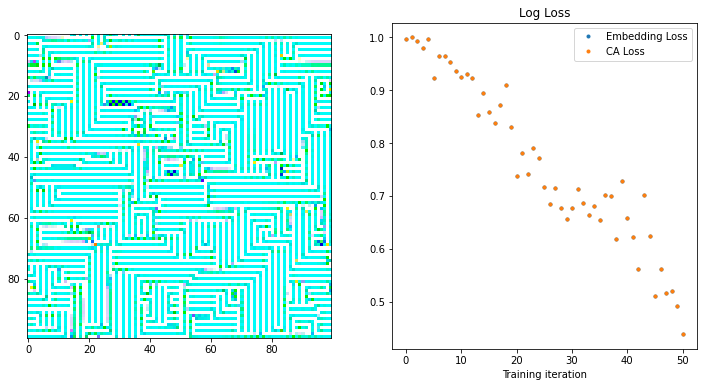

t=51, loss_emb=0.6121, loss_ca=0.6121
t=52, loss_emb=0.4869, loss_ca=0.4869
t=53, loss_emb=0.5962, loss_ca=0.5962
t=54, loss_emb=0.4926, loss_ca=0.4926
t=55, loss_emb=0.4842, loss_ca=0.4842


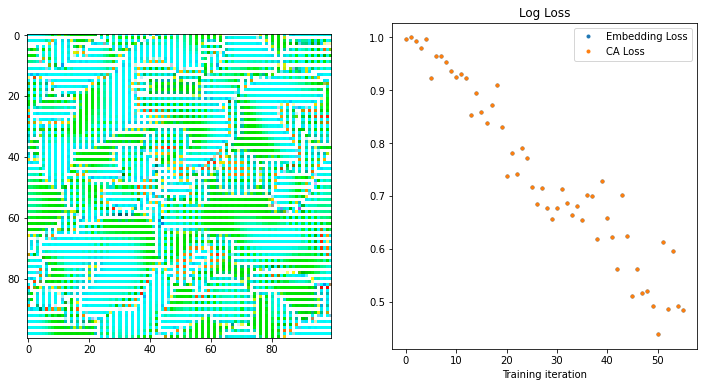

t=56, loss_emb=0.4278, loss_ca=0.4278
t=57, loss_emb=0.5363, loss_ca=0.5363
t=58, loss_emb=0.4489, loss_ca=0.4489
t=59, loss_emb=0.4293, loss_ca=0.4293
t=60, loss_emb=0.5516, loss_ca=0.5516


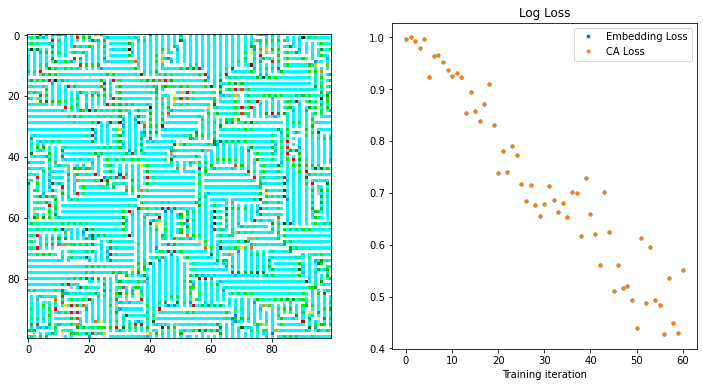

t=61, loss_emb=0.4969, loss_ca=0.4969
t=62, loss_emb=0.5632, loss_ca=0.5632
t=63, loss_emb=0.6343, loss_ca=0.6343
t=64, loss_emb=0.5827, loss_ca=0.5827
t=65, loss_emb=0.5064, loss_ca=0.5064


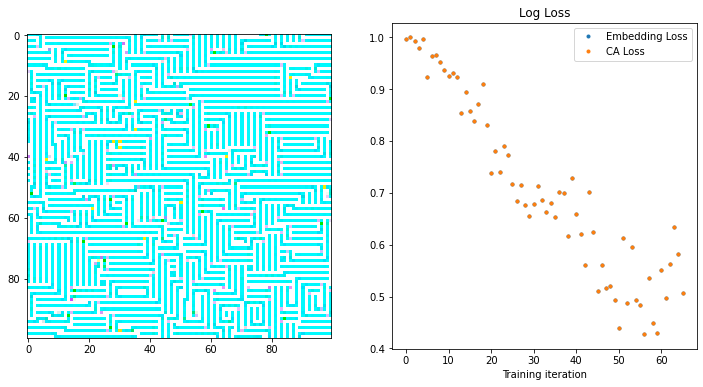

t=66, loss_emb=0.5180, loss_ca=0.5180
t=67, loss_emb=0.5500, loss_ca=0.5500
t=68, loss_emb=0.5614, loss_ca=0.5614
t=69, loss_emb=0.5374, loss_ca=0.5374
t=70, loss_emb=0.5200, loss_ca=0.5200


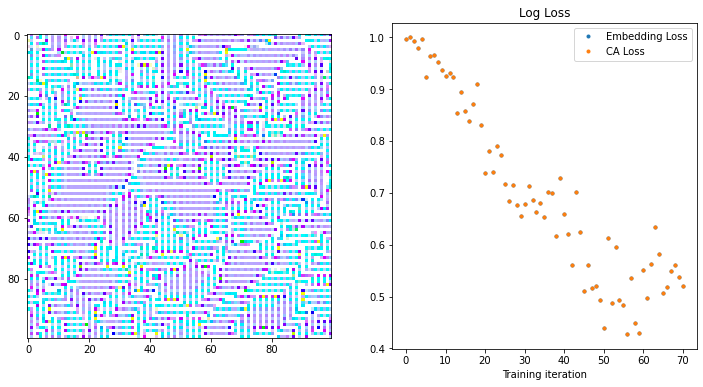

t=71, loss_emb=0.5645, loss_ca=0.5645
t=72, loss_emb=0.4966, loss_ca=0.4966
t=73, loss_emb=0.5610, loss_ca=0.5610
t=74, loss_emb=0.4928, loss_ca=0.4928
t=75, loss_emb=0.5139, loss_ca=0.5139


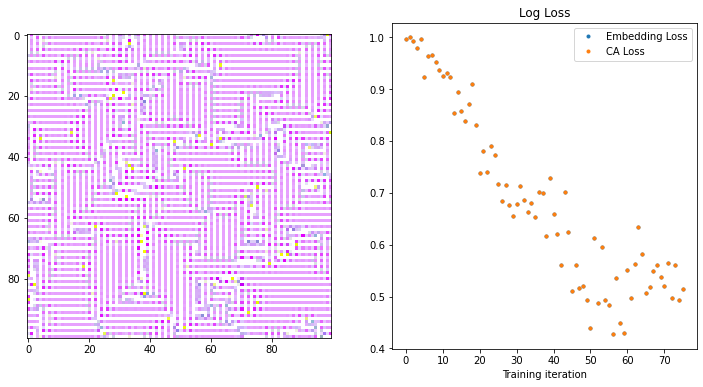

t=76, loss_emb=0.5170, loss_ca=0.5170
t=77, loss_emb=0.5099, loss_ca=0.5099
t=78, loss_emb=0.5247, loss_ca=0.5247
t=79, loss_emb=0.5108, loss_ca=0.5108
t=80, loss_emb=0.4227, loss_ca=0.4227


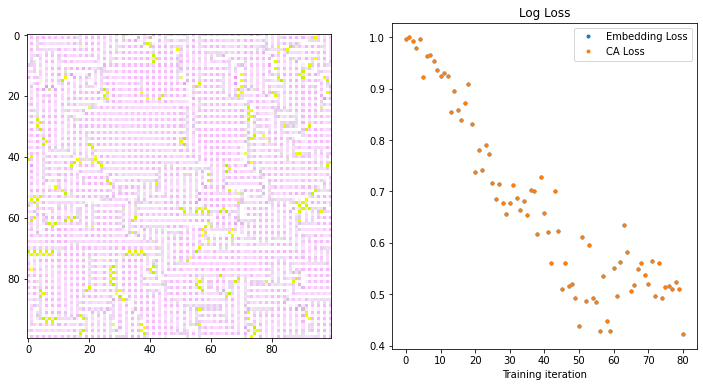

t=81, loss_emb=0.4976, loss_ca=0.4976
t=82, loss_emb=0.4559, loss_ca=0.4559
t=83, loss_emb=0.4455, loss_ca=0.4455
t=84, loss_emb=0.4322, loss_ca=0.4322
t=85, loss_emb=0.4113, loss_ca=0.4113


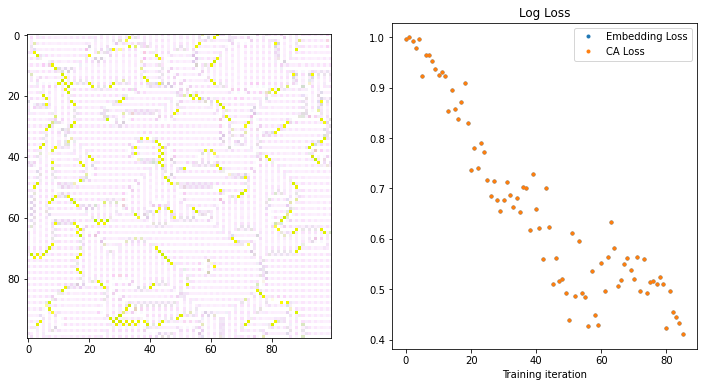

t=86, loss_emb=0.5553, loss_ca=0.5553
t=87, loss_emb=0.4939, loss_ca=0.4939
t=88, loss_emb=0.5563, loss_ca=0.5563
t=89, loss_emb=0.4968, loss_ca=0.4968
t=90, loss_emb=0.5340, loss_ca=0.5340


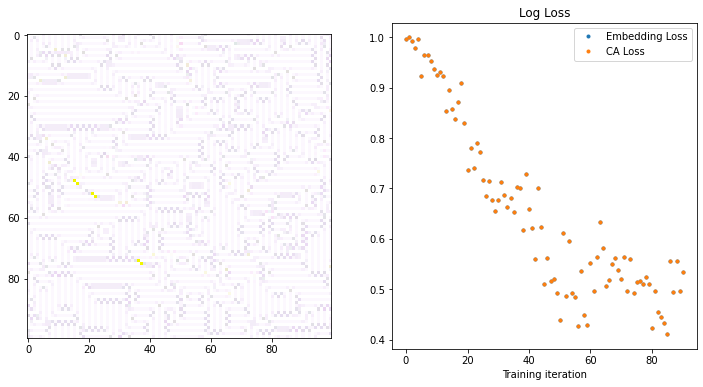

t=91, loss_emb=0.4503, loss_ca=0.4503
t=92, loss_emb=0.5294, loss_ca=0.5294
t=93, loss_emb=0.5147, loss_ca=0.5147
t=94, loss_emb=0.5037, loss_ca=0.5037
t=95, loss_emb=0.5029, loss_ca=0.5029


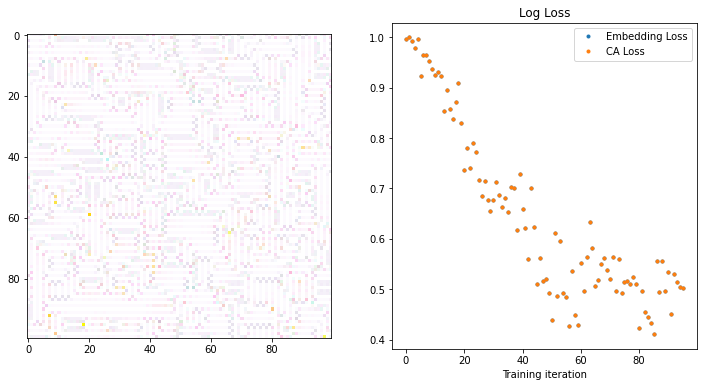

t=96, loss_emb=0.4816, loss_ca=0.4816
t=97, loss_emb=0.4997, loss_ca=0.4997
t=98, loss_emb=0.5948, loss_ca=0.5948
t=99, loss_emb=0.5344, loss_ca=0.5344
t=100, loss_emb=0.5242, loss_ca=0.5242


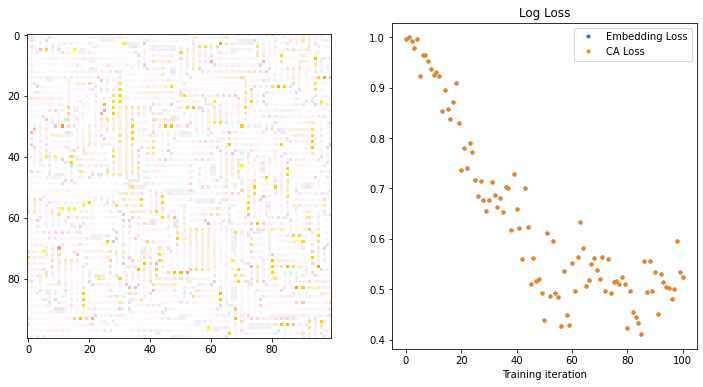

t=101, loss_emb=0.4505, loss_ca=0.4505
t=102, loss_emb=0.5154, loss_ca=0.5154
t=103, loss_emb=0.4984, loss_ca=0.4984
t=104, loss_emb=0.4880, loss_ca=0.4880
t=105, loss_emb=0.4175, loss_ca=0.4175


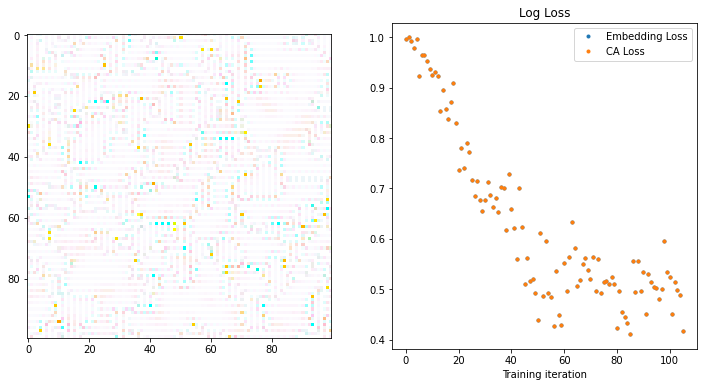

t=106, loss_emb=0.5085, loss_ca=0.5085
t=107, loss_emb=0.4278, loss_ca=0.4278
t=108, loss_emb=0.4843, loss_ca=0.4843
t=109, loss_emb=0.4509, loss_ca=0.4509
t=110, loss_emb=0.4259, loss_ca=0.4259


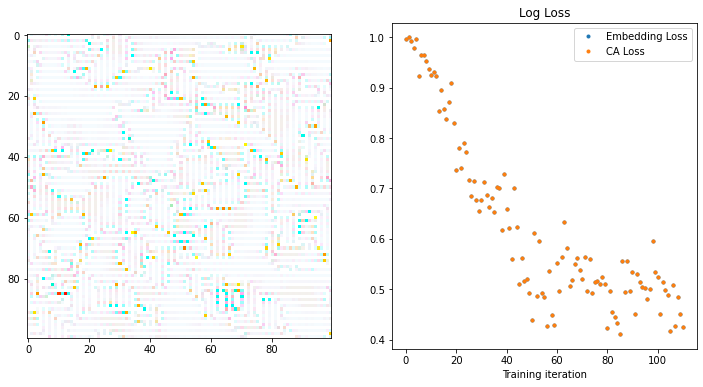

t=111, loss_emb=0.5179, loss_ca=0.5179
t=112, loss_emb=0.4649, loss_ca=0.4649
t=113, loss_emb=0.3301, loss_ca=0.3301
t=114, loss_emb=0.5412, loss_ca=0.5412
t=115, loss_emb=0.4131, loss_ca=0.4131


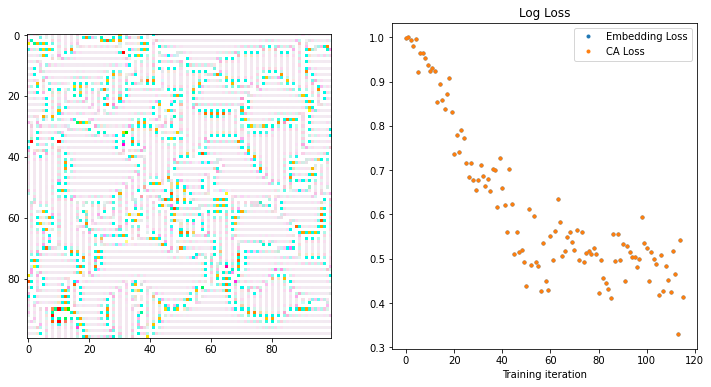

t=116, loss_emb=0.4102, loss_ca=0.4102
t=117, loss_emb=0.3972, loss_ca=0.3972
t=118, loss_emb=0.4281, loss_ca=0.4281
t=119, loss_emb=0.5365, loss_ca=0.5365
t=120, loss_emb=0.4949, loss_ca=0.4949


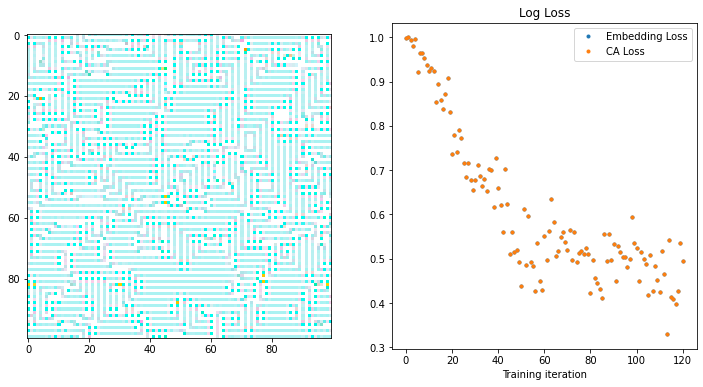

t=121, loss_emb=0.5417, loss_ca=0.5417
t=122, loss_emb=0.4035, loss_ca=0.4035
t=123, loss_emb=0.4451, loss_ca=0.4451
t=124, loss_emb=0.3967, loss_ca=0.3967
t=125, loss_emb=0.3502, loss_ca=0.3502


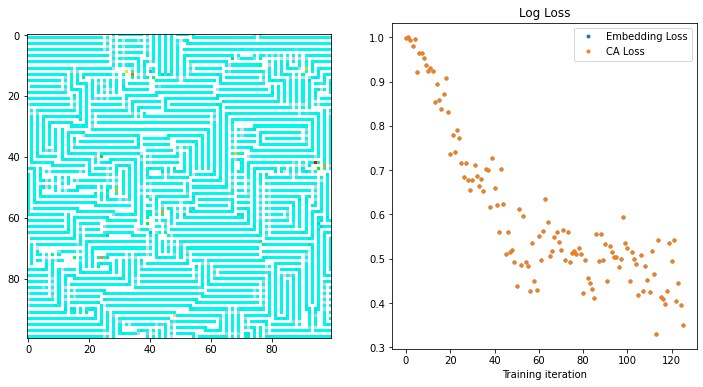

t=126, loss_emb=0.3470, loss_ca=0.3470
t=127, loss_emb=0.3486, loss_ca=0.3486
t=128, loss_emb=0.5614, loss_ca=0.5614
t=129, loss_emb=0.6356, loss_ca=0.6356
t=130, loss_emb=0.6881, loss_ca=0.6881


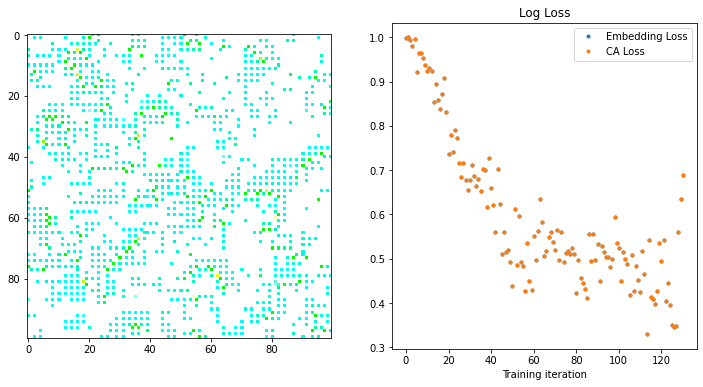

t=131, loss_emb=0.6121, loss_ca=0.6121
t=132, loss_emb=0.5666, loss_ca=0.5666
t=133, loss_emb=0.5438, loss_ca=0.5438
t=134, loss_emb=0.5689, loss_ca=0.5689
t=135, loss_emb=0.5894, loss_ca=0.5894


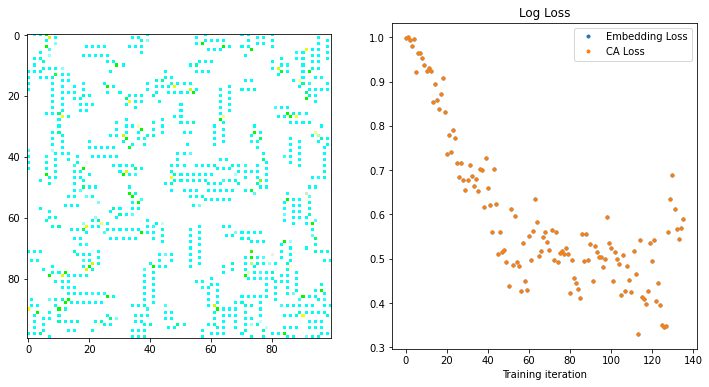

t=136, loss_emb=0.5568, loss_ca=0.5568
t=137, loss_emb=0.5387, loss_ca=0.5387
t=138, loss_emb=0.5231, loss_ca=0.5231
t=139, loss_emb=0.6751, loss_ca=0.6751
t=140, loss_emb=0.7158, loss_ca=0.7158


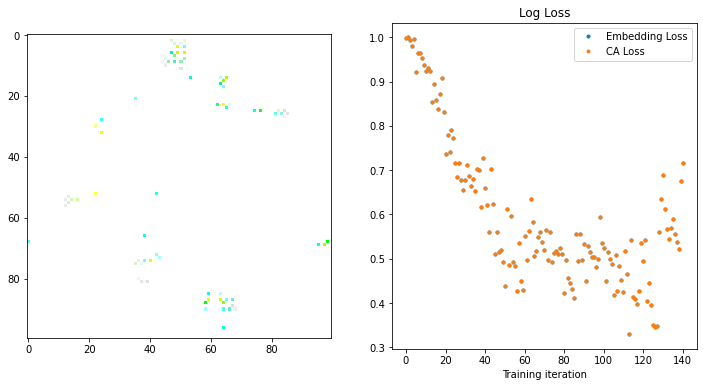

t=141, loss_emb=1.0000, loss_ca=1.0000
t=142, loss_emb=1.0000, loss_ca=1.0000
t=143, loss_emb=1.0000, loss_ca=1.0000
t=144, loss_emb=1.0000, loss_ca=1.0000
t=145, loss_emb=1.0000, loss_ca=1.0000


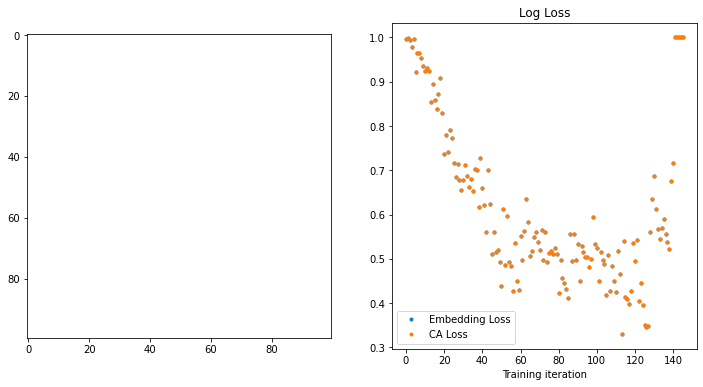

t=146, loss_emb=1.0000, loss_ca=1.0000
t=147, loss_emb=1.0000, loss_ca=1.0000
t=148, loss_emb=1.0000, loss_ca=1.0000
t=149, loss_emb=1.0000, loss_ca=1.0000
t=150, loss_emb=1.0000, loss_ca=1.0000


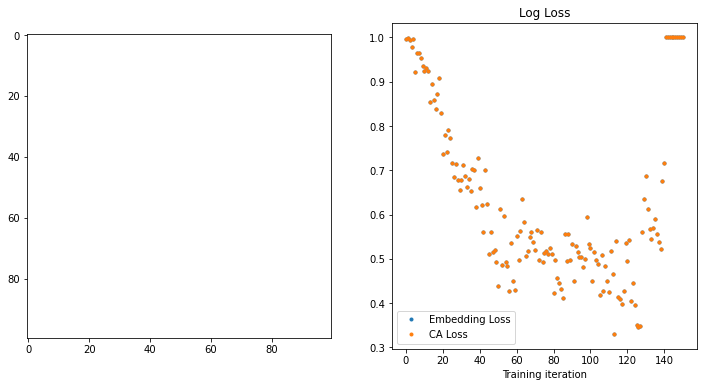

t=151, loss_emb=1.0000, loss_ca=1.0000
t=152, loss_emb=1.0000, loss_ca=1.0000
t=153, loss_emb=1.0000, loss_ca=1.0000
t=154, loss_emb=1.0000, loss_ca=1.0000
t=155, loss_emb=1.0000, loss_ca=1.0000


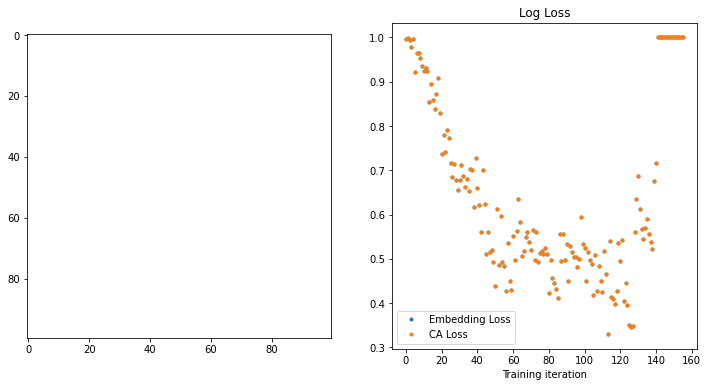

t=156, loss_emb=1.0000, loss_ca=1.0000
t=157, loss_emb=1.0000, loss_ca=1.0000
t=158, loss_emb=1.0000, loss_ca=1.0000
t=159, loss_emb=1.0000, loss_ca=1.0000
t=160, loss_emb=1.0000, loss_ca=1.0000


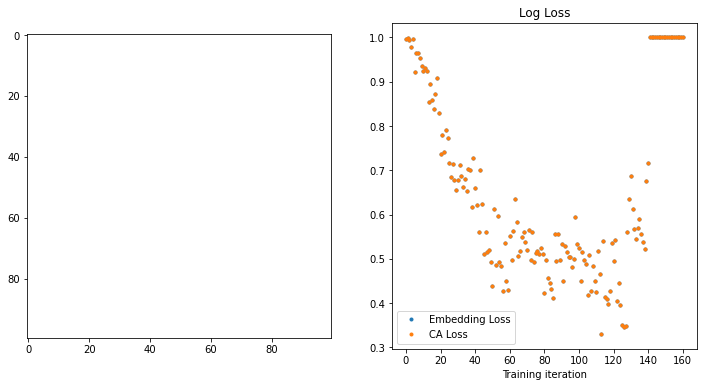

t=161, loss_emb=1.0000, loss_ca=1.0000
t=162, loss_emb=1.0000, loss_ca=1.0000
t=163, loss_emb=1.0000, loss_ca=1.0000
t=164, loss_emb=1.0000, loss_ca=1.0000
t=165, loss_emb=1.0000, loss_ca=1.0000


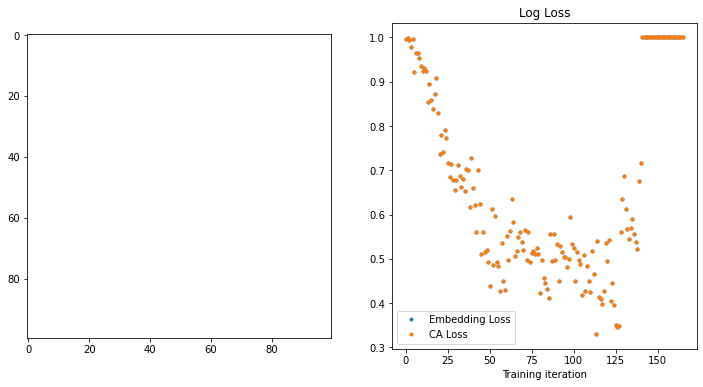

t=166, loss_emb=1.0000, loss_ca=1.0000
t=167, loss_emb=1.0000, loss_ca=1.0000
t=168, loss_emb=1.0000, loss_ca=1.0000
t=169, loss_emb=1.0000, loss_ca=1.0000
t=170, loss_emb=1.0000, loss_ca=1.0000


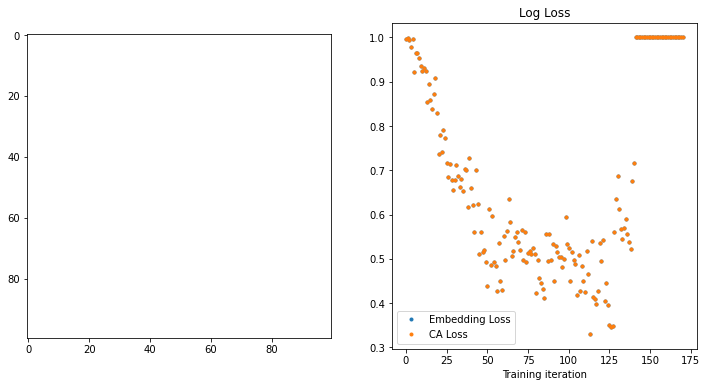

t=171, loss_emb=1.0000, loss_ca=1.0000
t=172, loss_emb=1.0000, loss_ca=1.0000
t=173, loss_emb=1.0000, loss_ca=1.0000
t=174, loss_emb=1.0000, loss_ca=1.0000
t=175, loss_emb=1.0000, loss_ca=1.0000


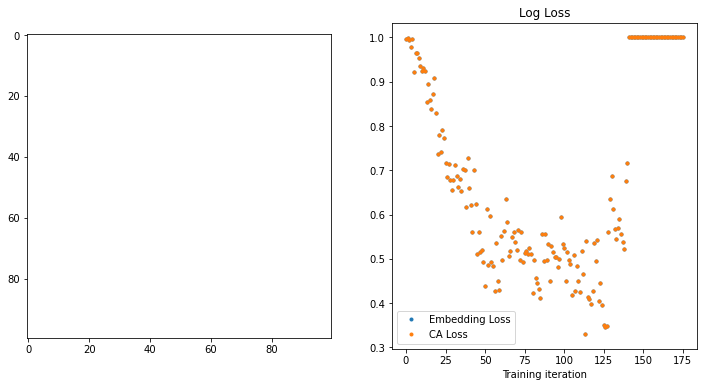

t=176, loss_emb=1.0000, loss_ca=1.0000
t=177, loss_emb=1.0000, loss_ca=1.0000
t=178, loss_emb=1.0000, loss_ca=1.0000
t=179, loss_emb=1.0000, loss_ca=1.0000
t=180, loss_emb=1.0000, loss_ca=1.0000


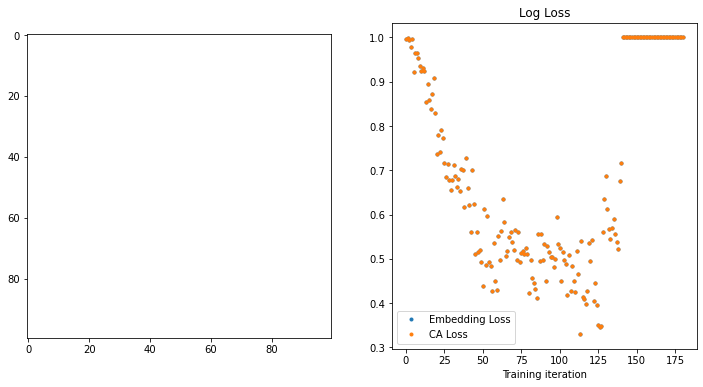

t=181, loss_emb=1.0000, loss_ca=1.0000
t=182, loss_emb=1.0000, loss_ca=1.0000
t=183, loss_emb=1.0000, loss_ca=1.0000
t=184, loss_emb=1.0000, loss_ca=1.0000
t=185, loss_emb=1.0000, loss_ca=1.0000


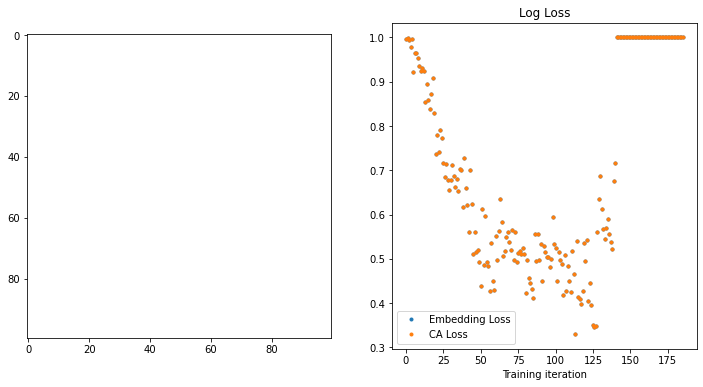

t=186, loss_emb=1.0000, loss_ca=1.0000
t=187, loss_emb=1.0000, loss_ca=1.0000
t=188, loss_emb=1.0000, loss_ca=1.0000
t=189, loss_emb=1.0000, loss_ca=1.0000
t=190, loss_emb=1.0000, loss_ca=1.0000


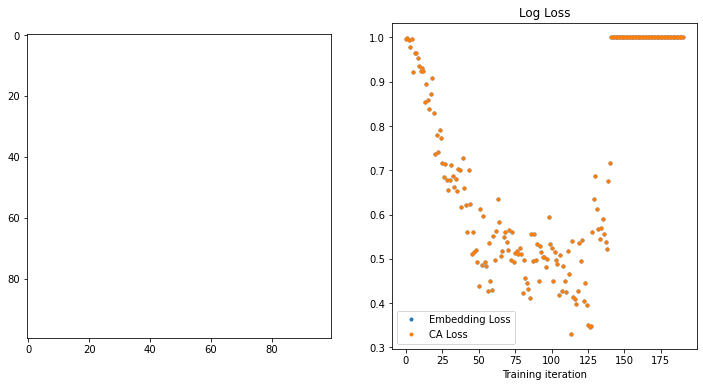

t=191, loss_emb=1.0000, loss_ca=1.0000
t=192, loss_emb=1.0000, loss_ca=1.0000
t=193, loss_emb=1.0000, loss_ca=1.0000
t=194, loss_emb=1.0000, loss_ca=1.0000
t=195, loss_emb=1.0000, loss_ca=1.0000


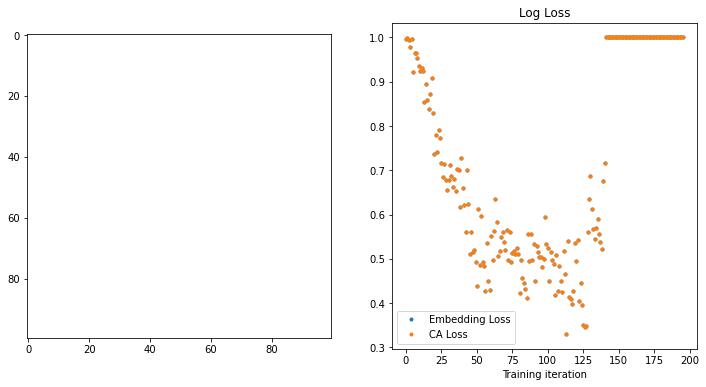

t=196, loss_emb=1.0000, loss_ca=1.0000
t=197, loss_emb=1.0000, loss_ca=1.0000
t=198, loss_emb=1.0000, loss_ca=1.0000
t=199, loss_emb=1.0000, loss_ca=1.0000
t=200, loss_emb=1.0000, loss_ca=1.0000


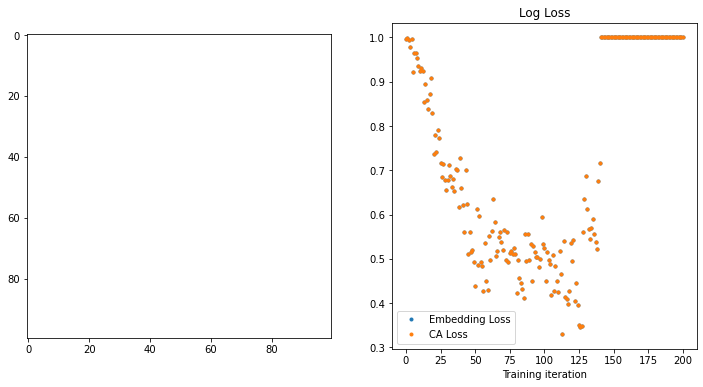

t=201, loss_emb=1.0000, loss_ca=1.0000
t=202, loss_emb=1.0000, loss_ca=1.0000
t=203, loss_emb=1.0000, loss_ca=1.0000
t=204, loss_emb=1.0000, loss_ca=1.0000
t=205, loss_emb=1.0000, loss_ca=1.0000


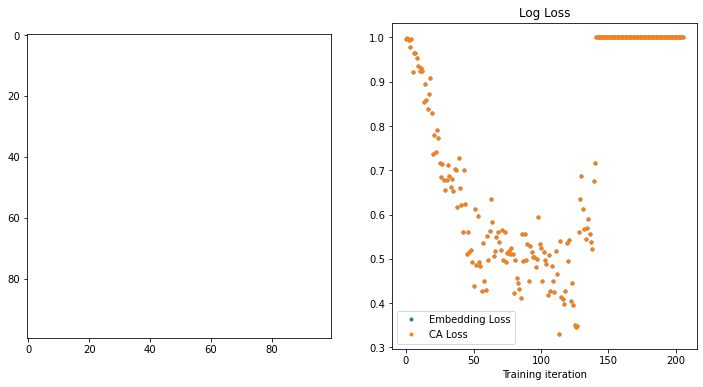

t=206, loss_emb=1.0000, loss_ca=1.0000
t=207, loss_emb=1.0000, loss_ca=1.0000
t=208, loss_emb=1.0000, loss_ca=1.0000
t=209, loss_emb=1.0000, loss_ca=1.0000
t=210, loss_emb=1.0000, loss_ca=1.0000


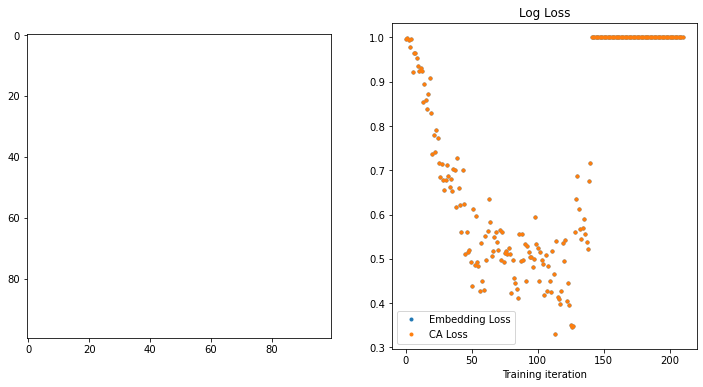

t=211, loss_emb=1.0000, loss_ca=1.0000
t=212, loss_emb=1.0000, loss_ca=1.0000
t=213, loss_emb=1.0000, loss_ca=1.0000
t=214, loss_emb=1.0000, loss_ca=1.0000
t=215, loss_emb=1.0000, loss_ca=1.0000


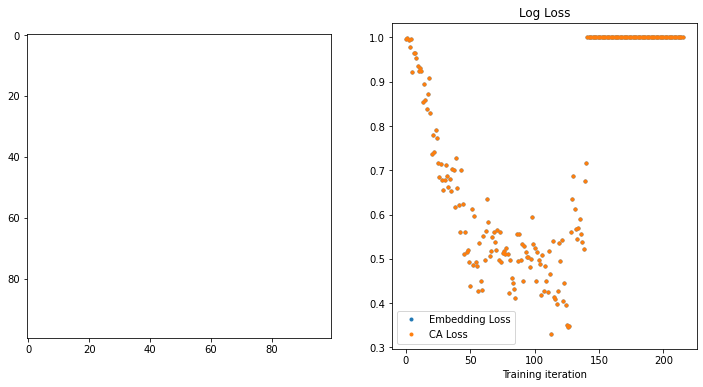

t=216, loss_emb=1.0000, loss_ca=1.0000
t=217, loss_emb=1.0000, loss_ca=1.0000
t=218, loss_emb=1.0000, loss_ca=1.0000
t=219, loss_emb=1.0000, loss_ca=1.0000
t=220, loss_emb=1.0000, loss_ca=1.0000


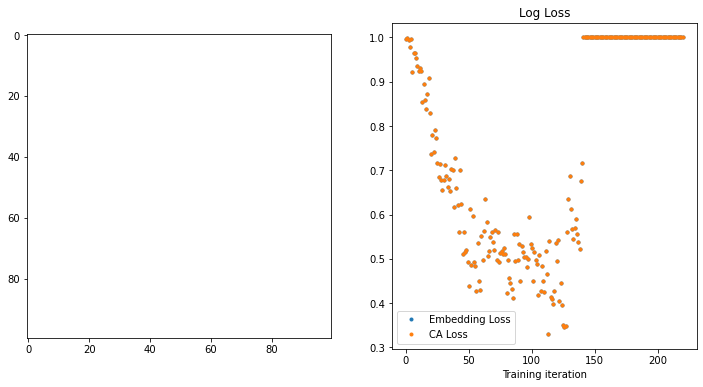

t=221, loss_emb=1.0000, loss_ca=1.0000
t=222, loss_emb=1.0000, loss_ca=1.0000
t=223, loss_emb=1.0000, loss_ca=1.0000
t=224, loss_emb=1.0000, loss_ca=1.0000
t=225, loss_emb=1.0000, loss_ca=1.0000


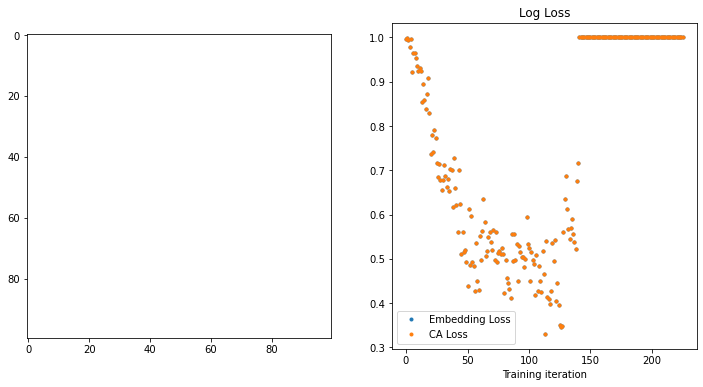

t=226, loss_emb=1.0000, loss_ca=1.0000
t=227, loss_emb=1.0000, loss_ca=1.0000
t=228, loss_emb=1.0000, loss_ca=1.0000
t=229, loss_emb=1.0000, loss_ca=1.0000
t=230, loss_emb=1.0000, loss_ca=1.0000


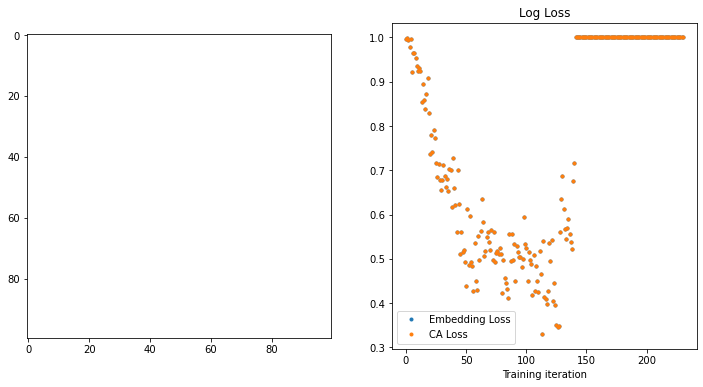

t=231, loss_emb=1.0000, loss_ca=1.0000
t=232, loss_emb=1.0000, loss_ca=1.0000
t=233, loss_emb=1.0000, loss_ca=1.0000
t=234, loss_emb=1.0000, loss_ca=1.0000
t=235, loss_emb=1.0000, loss_ca=1.0000


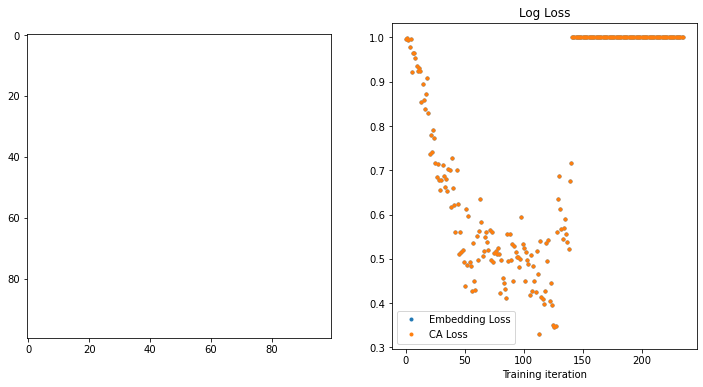

t=236, loss_emb=1.0000, loss_ca=1.0000
t=237, loss_emb=1.0000, loss_ca=1.0000
t=238, loss_emb=1.0000, loss_ca=1.0000
t=239, loss_emb=1.0000, loss_ca=1.0000
t=240, loss_emb=1.0000, loss_ca=1.0000


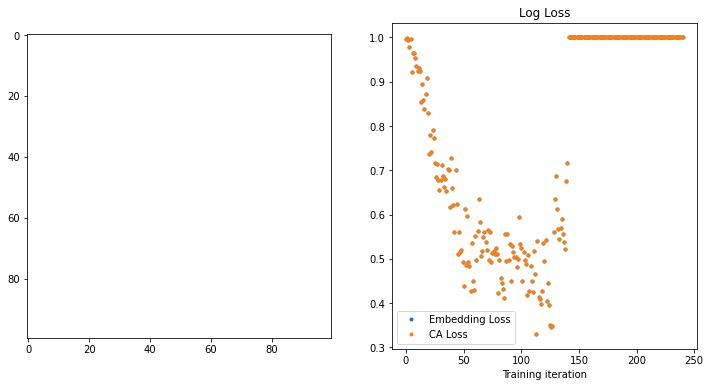

t=241, loss_emb=1.0000, loss_ca=1.0000
t=242, loss_emb=1.0000, loss_ca=1.0000
t=243, loss_emb=1.0000, loss_ca=1.0000
t=244, loss_emb=1.0000, loss_ca=1.0000
t=245, loss_emb=1.0000, loss_ca=1.0000


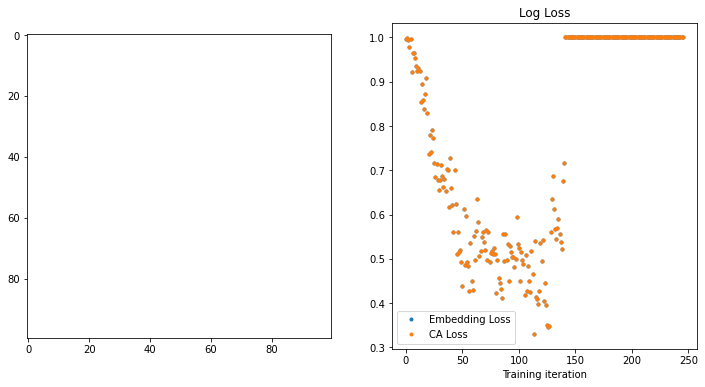

t=246, loss_emb=1.0000, loss_ca=1.0000
t=247, loss_emb=1.0000, loss_ca=1.0000
t=248, loss_emb=1.0000, loss_ca=1.0000
t=249, loss_emb=1.0000, loss_ca=1.0000
t=250, loss_emb=1.0000, loss_ca=1.0000


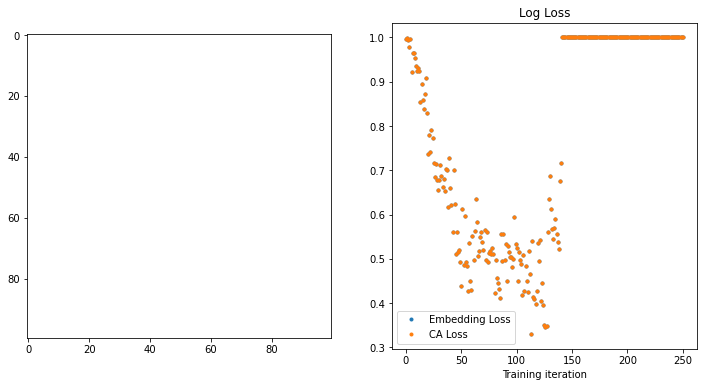

t=251, loss_emb=1.0000, loss_ca=1.0000
t=252, loss_emb=1.0000, loss_ca=1.0000
t=253, loss_emb=1.0000, loss_ca=1.0000
t=254, loss_emb=1.0000, loss_ca=1.0000
t=255, loss_emb=1.0000, loss_ca=1.0000


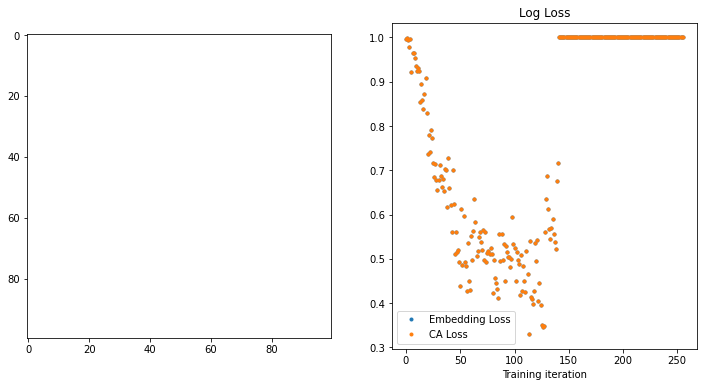

t=256, loss_emb=1.0000, loss_ca=1.0000
t=257, loss_emb=1.0000, loss_ca=1.0000
t=258, loss_emb=1.0000, loss_ca=1.0000
t=259, loss_emb=1.0000, loss_ca=1.0000
t=260, loss_emb=1.0000, loss_ca=1.0000


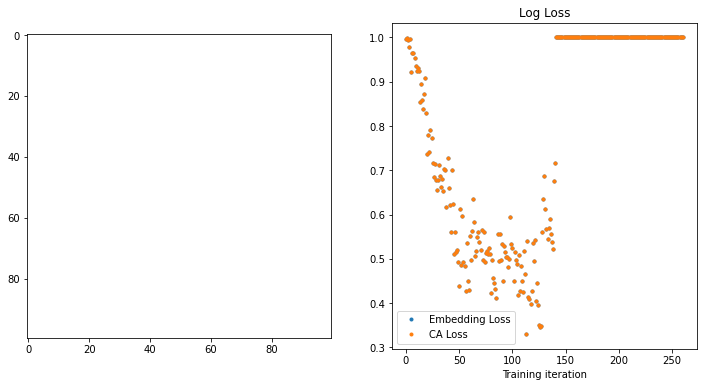

t=261, loss_emb=1.0000, loss_ca=1.0000
t=262, loss_emb=1.0000, loss_ca=1.0000
t=263, loss_emb=1.0000, loss_ca=1.0000
t=264, loss_emb=1.0000, loss_ca=1.0000
t=265, loss_emb=1.0000, loss_ca=1.0000


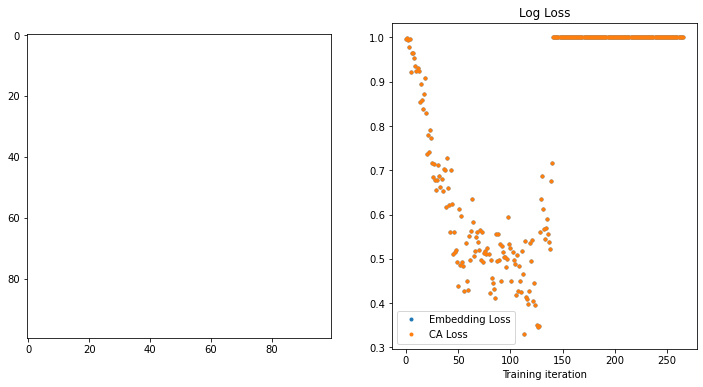

t=266, loss_emb=1.0000, loss_ca=1.0000
t=267, loss_emb=1.0000, loss_ca=1.0000
t=268, loss_emb=1.0000, loss_ca=1.0000
t=269, loss_emb=1.0000, loss_ca=1.0000
t=270, loss_emb=1.0000, loss_ca=1.0000


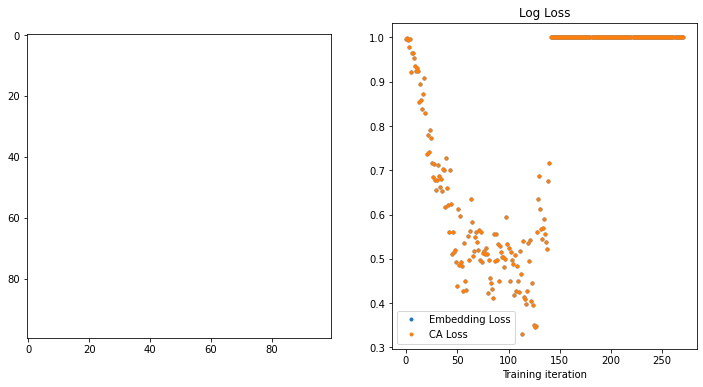

t=271, loss_emb=1.0000, loss_ca=1.0000
t=272, loss_emb=1.0000, loss_ca=1.0000
t=273, loss_emb=1.0000, loss_ca=1.0000
t=274, loss_emb=1.0000, loss_ca=1.0000
t=275, loss_emb=1.0000, loss_ca=1.0000


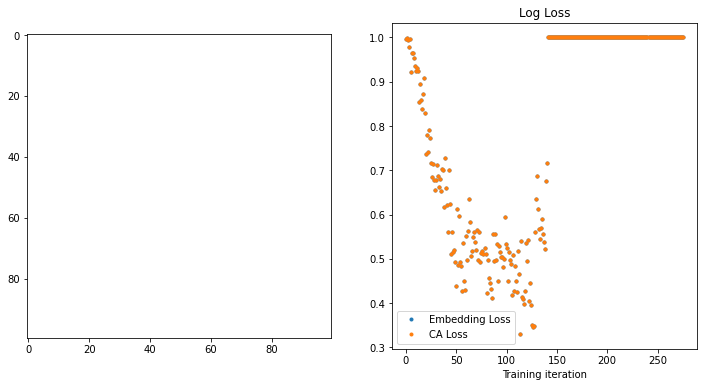

t=276, loss_emb=1.0000, loss_ca=1.0000
t=277, loss_emb=1.0000, loss_ca=1.0000
t=278, loss_emb=1.0000, loss_ca=1.0000
t=279, loss_emb=1.0000, loss_ca=1.0000
t=280, loss_emb=1.0000, loss_ca=1.0000


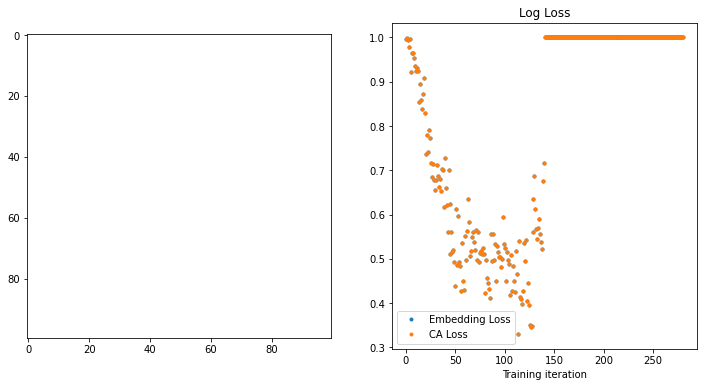

t=281, loss_emb=1.0000, loss_ca=1.0000
t=282, loss_emb=1.0000, loss_ca=1.0000
t=283, loss_emb=1.0000, loss_ca=1.0000
t=284, loss_emb=1.0000, loss_ca=1.0000
t=285, loss_emb=1.0000, loss_ca=1.0000


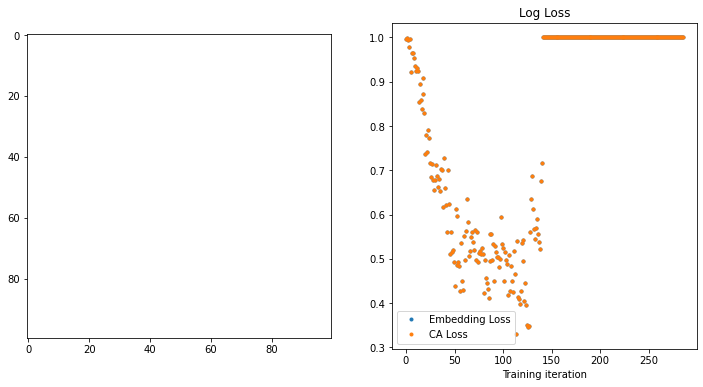

t=286, loss_emb=1.0000, loss_ca=1.0000
t=287, loss_emb=1.0000, loss_ca=1.0000
t=288, loss_emb=1.0000, loss_ca=1.0000
t=289, loss_emb=1.0000, loss_ca=1.0000
t=290, loss_emb=1.0000, loss_ca=1.0000


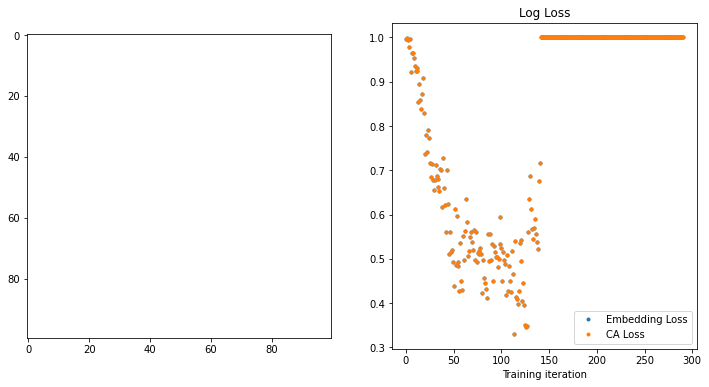

t=291, loss_emb=1.0000, loss_ca=1.0000
t=292, loss_emb=1.0000, loss_ca=1.0000
t=293, loss_emb=1.0000, loss_ca=1.0000
t=294, loss_emb=1.0000, loss_ca=1.0000
t=295, loss_emb=1.0000, loss_ca=1.0000


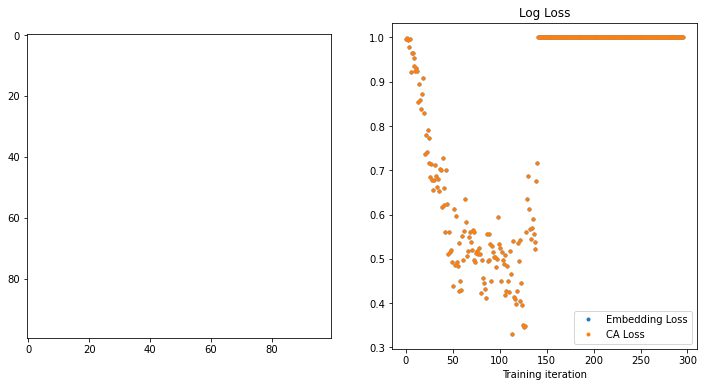

t=296, loss_emb=1.0000, loss_ca=1.0000
t=297, loss_emb=1.0000, loss_ca=1.0000
t=298, loss_emb=1.0000, loss_ca=1.0000
t=299, loss_emb=1.0000, loss_ca=1.0000
t=300, loss_emb=1.0000, loss_ca=1.0000


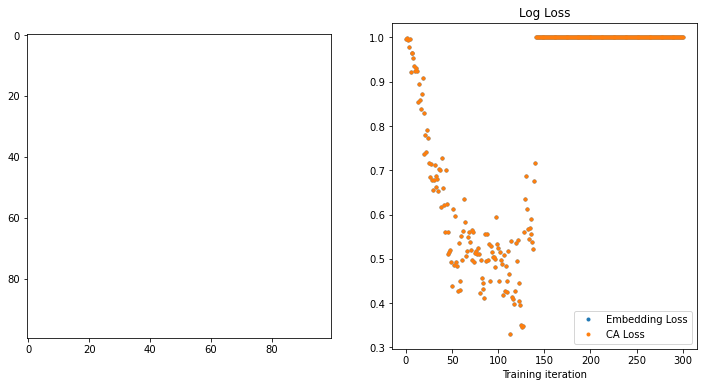

t=301, loss_emb=1.0000, loss_ca=1.0000
t=302, loss_emb=1.0000, loss_ca=1.0000
t=303, loss_emb=1.0000, loss_ca=1.0000
t=304, loss_emb=1.0000, loss_ca=1.0000
t=305, loss_emb=1.0000, loss_ca=1.0000


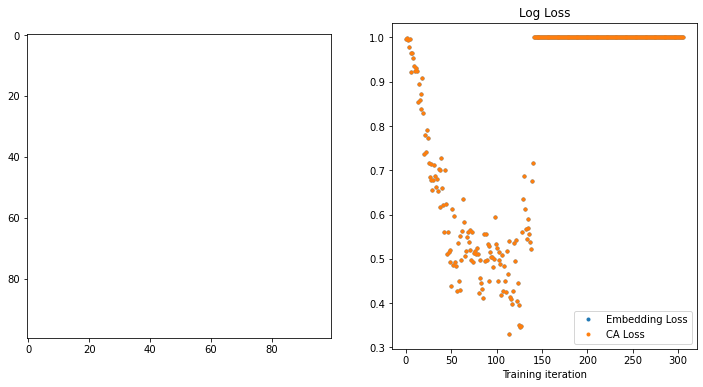

t=306, loss_emb=1.0000, loss_ca=1.0000
t=307, loss_emb=1.0000, loss_ca=1.0000
t=308, loss_emb=1.0000, loss_ca=1.0000
t=309, loss_emb=1.0000, loss_ca=1.0000
t=310, loss_emb=1.0000, loss_ca=1.0000


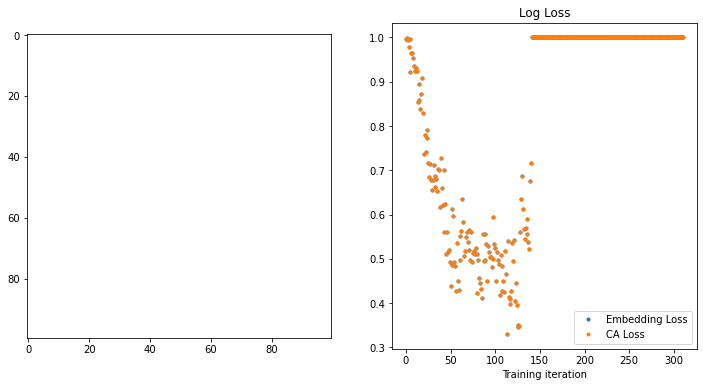

t=311, loss_emb=1.0000, loss_ca=1.0000
t=312, loss_emb=1.0000, loss_ca=1.0000
t=313, loss_emb=1.0000, loss_ca=1.0000
t=314, loss_emb=1.0000, loss_ca=1.0000
t=315, loss_emb=1.0000, loss_ca=1.0000


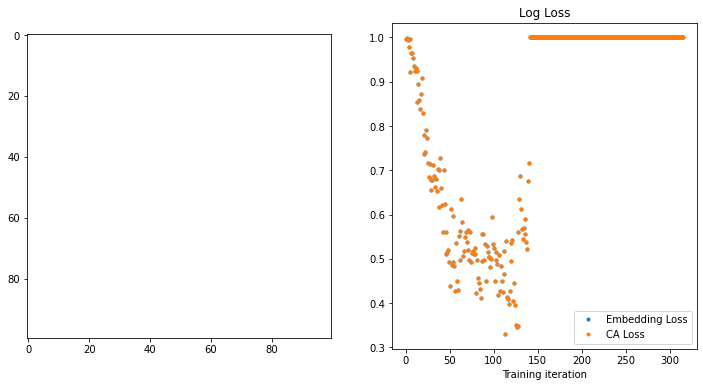

t=316, loss_emb=1.0000, loss_ca=1.0000
t=317, loss_emb=1.0000, loss_ca=1.0000
t=318, loss_emb=1.0000, loss_ca=1.0000
t=319, loss_emb=1.0000, loss_ca=1.0000
t=320, loss_emb=1.0000, loss_ca=1.0000


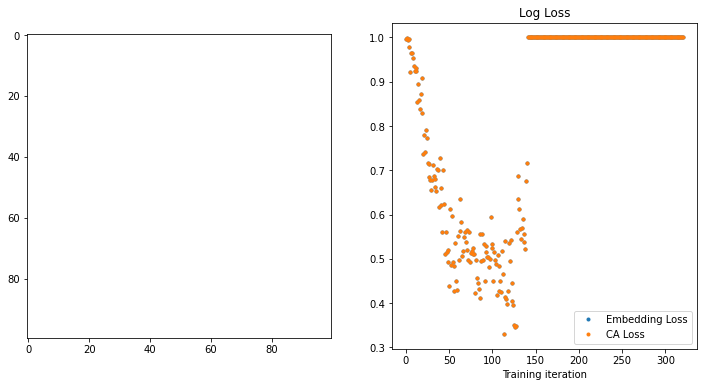

t=321, loss_emb=1.0000, loss_ca=1.0000
t=322, loss_emb=1.0000, loss_ca=1.0000
t=323, loss_emb=1.0000, loss_ca=1.0000
t=324, loss_emb=1.0000, loss_ca=1.0000
t=325, loss_emb=1.0000, loss_ca=1.0000


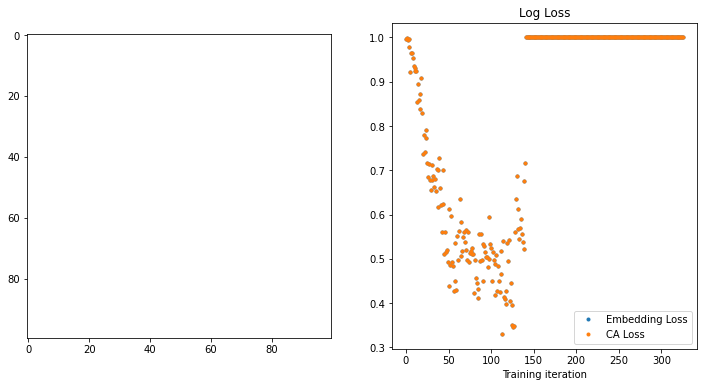

t=326, loss_emb=1.0000, loss_ca=1.0000
t=327, loss_emb=1.0000, loss_ca=1.0000
t=328, loss_emb=1.0000, loss_ca=1.0000
t=329, loss_emb=1.0000, loss_ca=1.0000
t=330, loss_emb=1.0000, loss_ca=1.0000


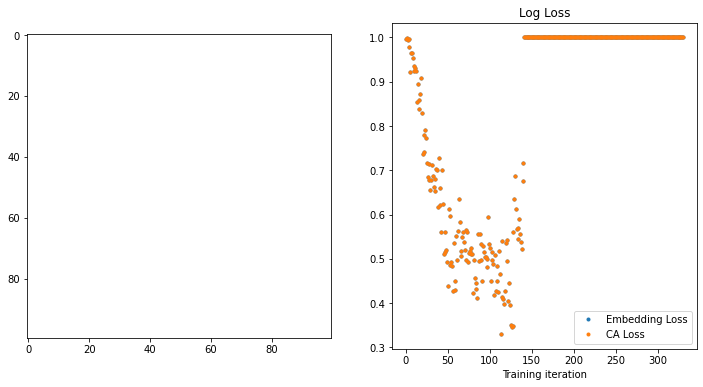

t=331, loss_emb=1.0000, loss_ca=1.0000
t=332, loss_emb=1.0000, loss_ca=1.0000
t=333, loss_emb=1.0000, loss_ca=1.0000
t=334, loss_emb=1.0000, loss_ca=1.0000
t=335, loss_emb=1.0000, loss_ca=1.0000


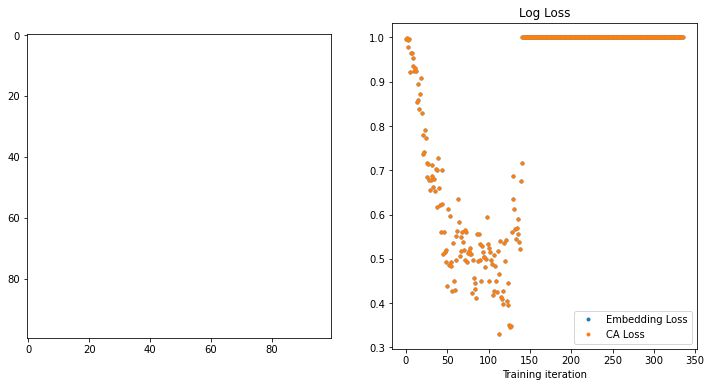

t=336, loss_emb=1.0000, loss_ca=1.0000
t=337, loss_emb=1.0000, loss_ca=1.0000
t=338, loss_emb=1.0000, loss_ca=1.0000
t=339, loss_emb=1.0000, loss_ca=1.0000
t=340, loss_emb=1.0000, loss_ca=1.0000


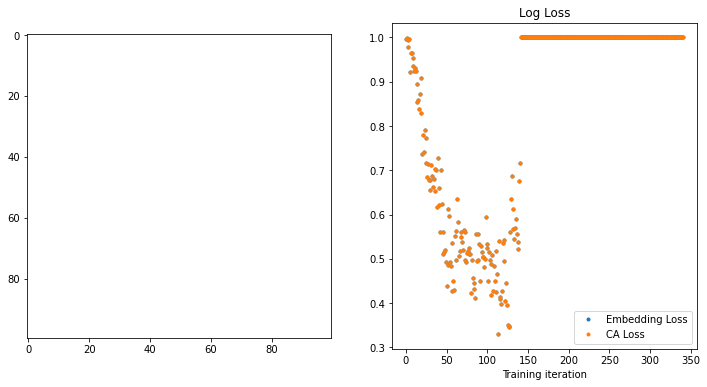

t=341, loss_emb=1.0000, loss_ca=1.0000
t=342, loss_emb=1.0000, loss_ca=1.0000
t=343, loss_emb=1.0000, loss_ca=1.0000
t=344, loss_emb=1.0000, loss_ca=1.0000
t=345, loss_emb=1.0000, loss_ca=1.0000


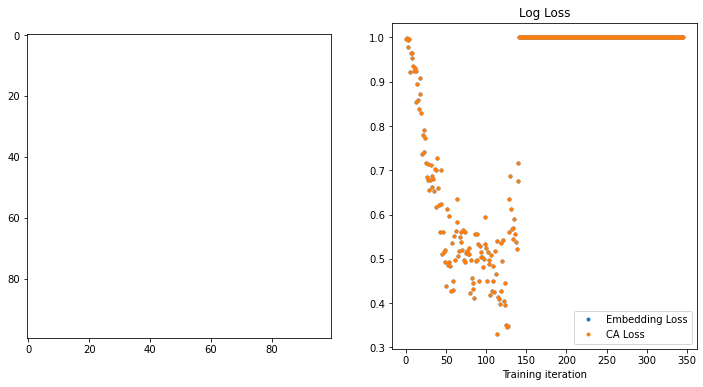

t=346, loss_emb=1.0000, loss_ca=1.0000
t=347, loss_emb=1.0000, loss_ca=1.0000
t=348, loss_emb=1.0000, loss_ca=1.0000
t=349, loss_emb=1.0000, loss_ca=1.0000
t=350, loss_emb=1.0000, loss_ca=1.0000


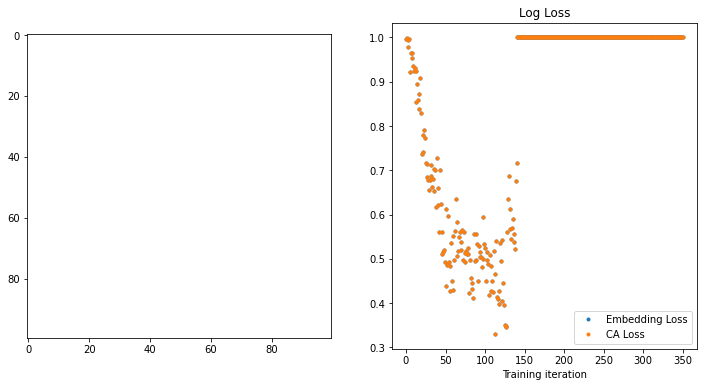

t=351, loss_emb=1.0000, loss_ca=1.0000
t=352, loss_emb=1.0000, loss_ca=1.0000
t=353, loss_emb=1.0000, loss_ca=1.0000
t=354, loss_emb=1.0000, loss_ca=1.0000
t=355, loss_emb=1.0000, loss_ca=1.0000


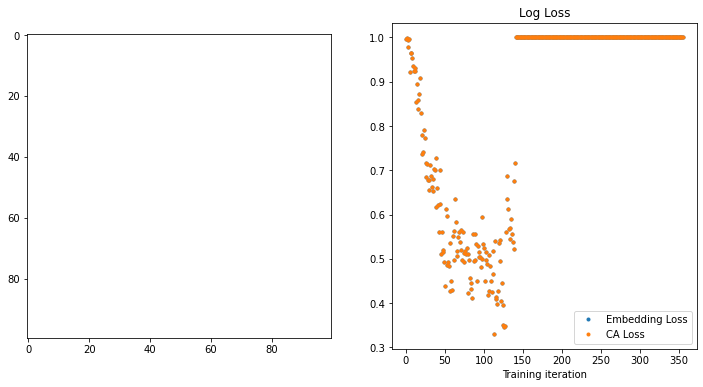

t=356, loss_emb=1.0000, loss_ca=1.0000
t=357, loss_emb=1.0000, loss_ca=1.0000
t=358, loss_emb=1.0000, loss_ca=1.0000
t=359, loss_emb=1.0000, loss_ca=1.0000


KeyboardInterrupt: 

In [128]:
mse = nn.MSELoss(reduction='mean')
res = 100
emb_loss = []
ca_loss = []
tloss = nn.TripletMarginLoss()
epochs=1


for epoch in range(epochs):
#     x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, res, res))).unsqueeze(0)
    stop_time = False
    i = 0
#     x = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, res, res))).unsqueeze(0)
#     x[:, 3:, res//2, res//2] = 1
    while i < 500 and stop_time == False:
        x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, res, res))).unsqueeze(0)
        
        for ii in range(200):
            x = torch.tanh(CA.forward(x, step_size=1, fire_rate=1)).detach()
        
#         if x.sum() == 0 or torch.isnan(x.sum()):
#             print('CA extint/NaN. Ending epoch.')
#             stop_time == True
#         else:
#             i += 1

        for ii in range(30):
            x = torch.tanh(CA.forward(x, step_size=1, fire_rate=1))
        
        if i%1 == 0:
            zs = embed.forward(x)
            loss = 0
            z1 = []
            z2 = []
            z3 = []
            hardfrac = 0
            for j in range(500):
                # pick a random coordinate and a nearby coordinate
                # TODO: FIX FOR PERIODIC BOUNDARIES
                x1 = np.random.randint(res)
                y1 = np.random.randint(res)
                x2 = (x1 + np.random.randint(9)) % res
                y2 = (y1 + np.random.randint(9)) % res

                x3 = x1
                y3 = y1

                z1a = zs[0,:,x1,y1]
                z2a = zs[0,:,x2,y2]

                stop = False
                while not stop:
                    x3 = np.random.randint(res)
                    y3 = np.random.randint(res)
                    if ((x3-x1)**2 + (y3-y1)**2 > 20*20):
                        z3a = zs[0,:,x3,y3]
                        d13 = torch.sum((z1a-z3a)**2)
                        d12 = torch.sum((z1a-z2a)**2)

                        if (d12>=d13):
                            hardfrac += 1
                            stop = True
                        else:
                            if np.random.rand()<1:
                                stop = True

                z1.append(zs[0,:,x1,y1].unsqueeze(0))
                z2.append(zs[0,:,x2,y2].unsqueeze(0))
                z3.append(zs[0,:,x3,y3].unsqueeze(0))

            z1 = torch.cat(z1,0)
            z2 = torch.cat(z2,0)
            z3 = torch.cat(z3,0)
            
            optim_ca.zero_grad()
#             loss = 1 / (1e-8 + tloss(z1,z2,z3)) - 1
#             ca_loss.append(loss.cpu().detach().item())
#             loss.backward(retain_graph=True)
            
            optim_emb.zero_grad()
            loss = tloss(z1,z2,z3)
            emb_loss.append(loss.cpu().detach().item())
            ca_loss.append(loss.cpu().detach().item())
            loss.backward()
            
            print(f't={i}, loss_emb={emb_loss[-1]:.4f}, loss_ca={ca_loss[-1]:.4f}')

            # normalize gradients
            for p in CA.parameters():
                if p.grad is not None:
                    p.grad = p.grad / (1e-8 + torch.norm(p.grad))

            optim_emb.step()
            optim_ca.step()
            x = x.detach()
        
        
        ##### PLOTTING THINGS #####
        if i % 5 == 0:
            nx = x.cpu().detach().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
            nx = rgba2rgb(nx)
            nx = np.uint8(nx*255.0)

#             clear_output(wait=True)
            fig1, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(nx)

#             fig2, ax2 = plt.subplots(1, 1, figsize=(6, 6))
            axes[1].plot((emb_loss), '.', label='Embedding Loss')
            axes[1].plot((ca_loss), '.', label='CA Loss')
            axes[1].set_title('Log Loss')
            axes[1].set_xlabel('Training iteration')
            axes[1].legend()
#             axes[1].set_aspect('equal', 'box')

            plt.show()
        ###########################
        
        i += 1
        


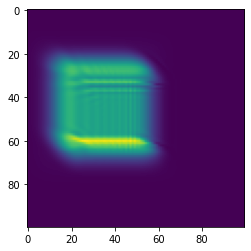

In [40]:
n_x = x.cpu().detach().numpy()[0, 15, :, :]
plt.imshow(n_x)

In [118]:
import umap

ModuleNotFoundError: No module named 'umap'

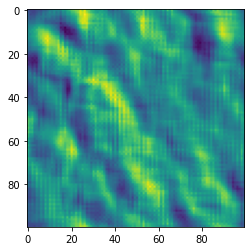

In [114]:
i = slice(0, 1)
im_z = zs.cpu().detach().numpy()[0, i, :, :].transpose(1, 2, 0)
if im_z.shape[2] == 1:
    im_z = im_z[:, :, 0]
plt.imshow(im_z)

In [188]:
im_z.shape[2]

1

In [357]:
for i in range(0, BATCH_SIZE):
    ex_img = np.array(imgs)[:, i, :, :, :]

    fname = time.strftime("%Y%m%d-%H%M%S") + f'_{i}'
    out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, (h, w), 3)

    for img in ex_img[:]:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        out.write(img)
    out.release()

# Run Trained Model

In [10]:
CA = torch.load('model/CA_3300_20200325-013406')

550


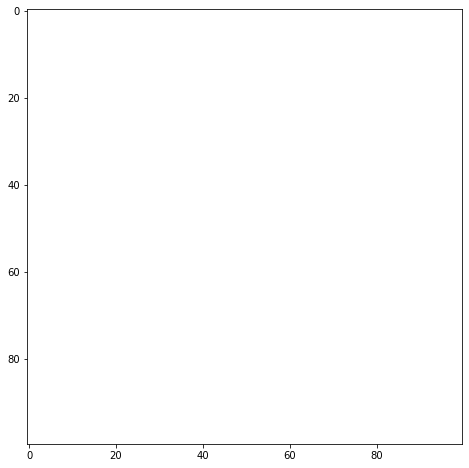

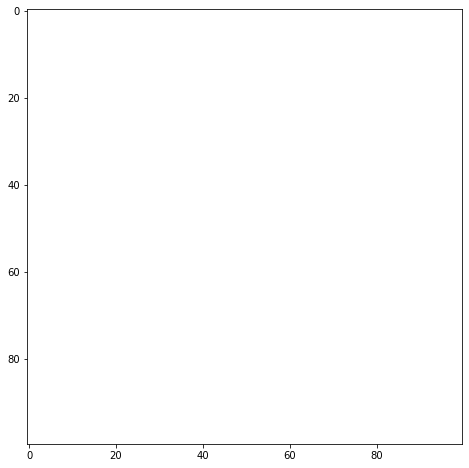

In [130]:
x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, res, res))).unsqueeze(0)
SIZE = 100
# x = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
# x[:, 3:, SIZE//2, SIZE//2] = 1
imgs = []

for i in range(600):
    
    with torch.no_grad():
        nx = x.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
    #     nx = np.uint8(nx*255.0)
        imgs.append(nx)

        x = torch.tanh(CA.forward(x, step_size=1, fire_rate=1))
        x = x.detach()


        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

In [32]:
fname = 'model/CA_model_' + time.strftime("%Y%m%d-%H%M%S") + '.pb'
torch.save(CA.dmodel, fname)

In [30]:
CA = CAModel()

CA.dmodel = torch.load(fname)
CA.cuda()

CAModel(
  (dmodel): Sequential(
    (conv1): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
  )
)